### Step 0 - Download data

In [1]:
## Download and upzip data set, only need to be done once
## download 
# curl -O https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip

## unzip
# unzip data.zip

## Connect AWS EC2 with Filezilla
# username carnd, password carnd, port 22

### Step 1 - Import modules and prep data

In [1]:
# Import modules
import csv
import cv2
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [3]:
# Fetch the header file of the pictures and the steering angle
lines = []
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

trainHeader, validHeader = train_test_split(lines[1:], test_size = 0.2)

In [6]:
# Data cleaning and pre-process, augmenting data by including left and right camera's data
def dataGenerator(header, batchSize = 32):
    n = len(header)
    while True:
        shuffle(header)
        for offset in range(0, n, batchSize):
            headerBatch = header[offset : offset + batchSize]
            images = []
            angles = []
            angleCorr = 0.2
            for headerSample in headerBatch:
                for i in range(3):
                    sourcePath = headerSample[i]
                    fileName = sourcePath.split('/')[-1]
                    curPath = 'data/IMG/' + fileName
                    image = cv2.imread(curPath)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    images.append(image)
                    images.append(cv2.flip(image,1))
                angleCenter = float(headerSample[3])
                angleLeft = angleCenter + angleCorr
                angleRight = angleCenter - angleCorr
                angles.append(angleCenter)
                angles.append(angleCenter*-1.0)
                angles.append(angleLeft)
                angles.append(angleLeft*-1.0)
                angles.append(angleRight)
                angles.append(angleRight*-1.0)
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

In [7]:
# Generate training and validation data set
trainGen = dataGenerator(trainHeader, batchSize = 32)
validGen = dataGenerator(validHeader, batchSize = 32)
trainLen = 6*len(trainHeader)
validLen = 6*len(validHeader)

### Step 2 - Build, train, validate and save the model

In [8]:
# Building model with keras, train and save the model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Convolution2D

model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape = (160, 320, 3)))
model.add(Cropping2D(cropping = ((50, 20),(0,0))))
model.add(Convolution2D(24,5,5, subsample = (2,2), activation = "relu"))
model.add(Convolution2D(36,5,5, subsample = (2,2), activation = "relu"))
model.add(Convolution2D(48,5,5, subsample = (2,2), activation = "relu"))
model.add(Convolution2D(64,3,3, activation = "relu"))
model.add(Convolution2D(64,3,3, activation = "relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss = 'mse', optimizer = 'adam')
trainHistory = model.fit_generator(trainGen, samples_per_epoch = trainLen,
                   validation_data = validGen, nb_val_samples = validLen, nb_epoch = 5)

model.save('modelV2.h5')

Using TensorFlow backend.


Epoch 1/5
38568/38568 [==============================] - 98s - loss: 0.0199 - val_loss: 0.0178
Epoch 2/5
38568/38568 [==============================] - 92s - loss: 0.0155 - val_loss: 0.0158
Epoch 3/5
38568/38568 [==============================] - 89s - loss: 0.0141 - val_loss: 0.0152
Epoch 4/5
38568/38568 [==============================] - 89s - loss: 0.0131 - val_loss: 0.0148
Epoch 5/5
38568/38568 [==============================] - 89s - loss: 0.0121 - val_loss: 0.0145


### Step 3 - Generate plots

dict_keys(['loss', 'val_loss'])


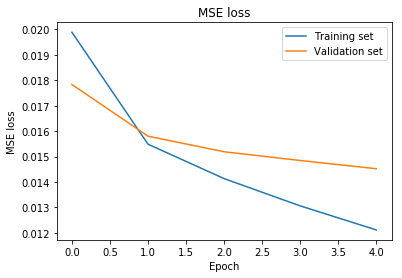

In [10]:
# Plot the training and validation loss for each epoch

print(trainHistory.history.keys())

fig = plt.figure()
plt.plot(trainHistory.history['loss'])
plt.plot(trainHistory.history['val_loss'])
plt.title('MSE loss')
plt.ylabel('MSE loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper right')
plt.show()
fig.savefig('examples/MESLoss')

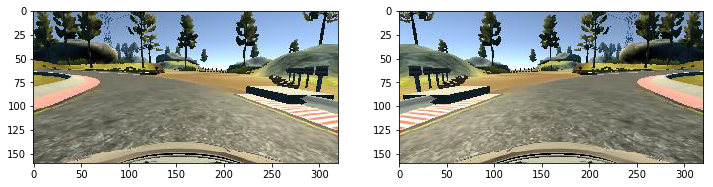

In [32]:
# Generating figures for report writing
def plotDemo():
    images = []
    lineEx =  lines[10]
    sourcePath = lineEx[0]
    fileName = sourcePath.split('/')[-1]
    curPath = './data/IMG/' + fileName
    image = cv2.imread(curPath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)
    images.append(cv2.flip(image,1))

    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(121)
    plt.imshow(images[0])
    ax = fig.add_subplot(122)
    plt.imshow(images[1])
    plt.show()
    fig.savefig('examples/Flips.jpeg',bbox_inches='tight')

plotDemo()